In [1]:
"""Diff losses - more loss :("""

import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn import TransformerEncoder
import ffn
import numpy as np
from binned_data_loading import *
from sklearn.preprocessing import MinMaxScaler
import sys

sys.path.append(os.path.dirname(os.path.abspath(f'/Users/ishanshastri/Desktop/nus/CPMF/energy_datasets/spain_energy_weather/sp_energy_loader.py')))
import sp_energy_loader as sp


In [2]:
# Constants
context_length = 7
predict_length = 1
batch_size=512
epochs=100

# Setting bin parameters (percentage bounds, and number of splits)
lower_bin = -100#%
upper_bin = 100#%
bin_range = 20

In [3]:
# Load spanish energy data into dataframe
df = sp.get_raw_dataframe()
df = sp.proc_dataframe_dates(df)

# Separate prices (univariate forecasting)
df_prices = df[['price actual']]
df_prices

,price actual
0,65.41
1,64.92
2,64.48
3,59.32
4,56.04
...,...
34988,73.60
34989,69.21
34990,67.53
34991,64.08


In [4]:
"""Scaling"""
# Scale data between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df_prices['price scaled'] = scaler.fit_transform(df_prices['price actual'].values.reshape(-1, 1))
scaler.data_min_, scaler.data_max_

/var/folders/2t/dh69lmc920l_h8vbm87mpzcw0000gn/T/ipykernel_80900/2914387650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices['price scaled'] = scaler.fit_transform(df_prices['price actual'].values.reshape(-1, 1))


(array([11.69]), array([110.35]))

In [5]:
# View data
df_prices

,price actual,price scaled
0,65.41,0.088992
1,64.92,0.079059
2,64.48,0.070140
3,59.32,-0.034462
4,56.04,-0.100953
...,...,...
34988,73.60,0.255017
34989,69.21,0.166025
34990,67.53,0.131968
34991,64.08,0.062031


In [6]:
"""Bin the data (quantization)"""
train_size = int(0.8*len(df_prices.index))
test_size = df.index-train_size

# Get binned prices and reverse map to transform quantized bins back to prices
df_prices['binned'], reverse_bin_map = bin_returns(df_prices['price scaled'], lower_bin=lower_bin, upper_bin=upper_bin, num_bins=bin_range, get_label_map=True)

df_train = df_prices[['binned']].iloc[:train_size]
df_test = df_prices[['binned']].iloc[train_size:]
df_train, df_test

/var/folders/2t/dh69lmc920l_h8vbm87mpzcw0000gn/T/ipykernel_80900/271033898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices['binned'], reverse_bin_map = bin_returns(df_prices['price scaled'], lower_bin=lower_bin, upper_bin=upper_bin, num_bins=bin_range, get_label_map=True)


(      binned
 0         10
 1         10
 2         10
 3          9
 4          9
 ...      ...
 27386      6
 27387      6
 27388      6
 27389      7
 27390      7
 
 [11204 rows x 1 columns],
       binned
 27391      9
 27393     10
 27400     11
 27401     11
 27402     11
 ...      ...
 34988     12
 34989     11
 34990     11
 34991     10
 34992     10
 
 [2801 rows x 1 columns])

In [7]:
df_prices

,price actual,price scaled,binned
0,65.41,0.088992,10
1,64.92,0.079059,10
2,64.48,0.070140,10
3,59.32,-0.034462,9
4,56.04,-0.100953,9
...,...,...,...
34988,73.60,0.255017,12
34989,69.21,0.166025,11
34990,67.53,0.131968,11
34991,64.08,0.062031,10


In [9]:
reverse_bin_map

{0: -inf,
 1: -1.0,
 2: -0.8888888888888888,
 3: -0.7777777777777777,
 4: -0.6666666666666667,
 5: -0.5555555555555556,
 6: -0.4444444444444444,
 7: -0.3333333333333334,
 8: -0.2222222222222223,
 9: -0.11111111111111115,
 10: 0.0,
 11: 0.11111111111111115,
 12: 0.22222222222222215,
 13: 0.33333333333333315,
 14: 0.4444444444444443,
 15: 0.5555555555555555,
 16: 0.6666666666666665,
 17: 0.7777777777777777,
 18: 0.8888888888888888,
 19: 1.0,
 20: inf}

<Axes: >

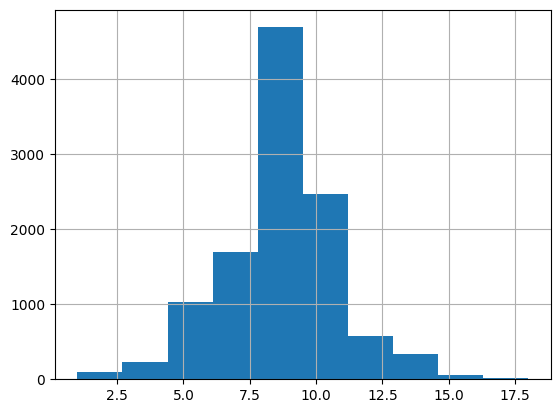

In [15]:
"""View distribution of quantized values"""
df_train['binned'].hist()

<Axes: >

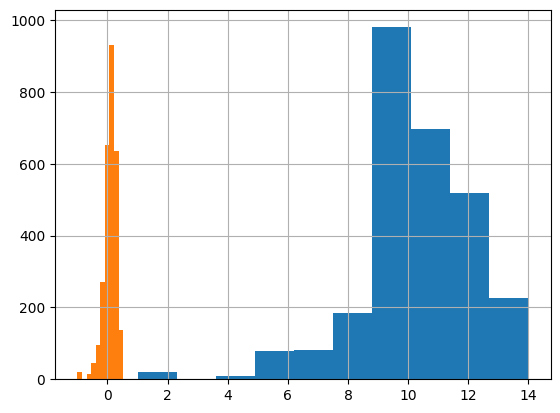

In [16]:
"""Make sure scaled and binned prices have a similar shape (scaled)"""
df_test['binned'].hist()
df_prices['price scaled'][train_size:].hist()

In [ ]:
"""Calculate proportions of value (representation fo above histogram) -- can be used during loss computation to give 
higher weight to values that are less frequent"""
proportions = torch.tensor(df_test['binned'].value_counts(sort=False))
proportions = 2-proportions/torch.max(proportions) # Want the values to be between 1 and 2
proportions, df_test['binned'].value_counts(sort=False)

(tensor([8.0000, 7.6606, 7.9828, 7.9656, 7.8291, 7.6439, 7.0424, 6.6849, 5.2189,
         2.9710, 1.5463, 1.0000, 1.9785, 5.0397, 7.5276, 8.0000, 8.0000, 8.0000,
         8.0000, 8.0000]),
 binned
 0       0
 1      20
 2       1
 3       2
 4      10
 5      21
 6      58
 7      81
 8     185
 9     392
 10    588
 11    697
 12    519
 13    199
 14     28
 15      0
 16      0
 17      0
 18      0
 19      0
 Name: count, dtype: int64)

In [20]:

import plotly.express as px

fig = px.line(df_prices, y='binned', title='Trend of Predicted Binned Returns and Scaled Returns')

fig.update_xaxes(title_text='Price Bin')
fig.update_yaxes(title_text='Time (indexed)')
fig.show()

In [21]:
"""Dataloader"""
class BucketDataSet(Dataset):
    def __init__(self, df:pd.DataFrame):
        self.len = len(df.index)
        self.src = df.to_dict(orient='list')#.values.reshape(-1, 1)

    def __getitem__(self, idx) -> torch.Tensor:
        return {
            k : torch.tensor(v[idx]).float().to('cpu') for k, v in self.src.items() #k:torch.tensor(self.src[k]) for k in self.src[idx]
        }

    def __len__(self):
        return self.len#(self.src)

In [22]:
"""Window Splitting"""
rolling_bins_train = get_rolling_window(df=df_train['binned'], context_length=context_length, predict_length=predict_length)
rolling_bins_test = get_rolling_window(df=df_test['binned'], context_length=context_length, predict_length=predict_length)
data_df_train = pd.DataFrame({'x':rolling_bins_train})
data_df_test = pd.DataFrame({'x':rolling_bins_test})

data_df_train, data_df_test

(                                  x
 0       [10, 10, 10, 9, 9, 8, 8, 8]
 1        [10, 10, 9, 9, 8, 8, 8, 7]
 2         [10, 9, 9, 8, 8, 8, 7, 8]
 3          [9, 9, 8, 8, 8, 7, 8, 9]
 4          [9, 8, 8, 8, 7, 8, 9, 9]
 ...                             ...
 11191  [8, 10, 11, 11, 10, 8, 7, 7]
 11192  [10, 11, 11, 10, 8, 7, 7, 6]
 11193   [11, 11, 10, 8, 7, 7, 6, 6]
 11194    [11, 10, 8, 7, 7, 6, 6, 6]
 11195     [10, 8, 7, 7, 6, 6, 6, 7]
 
 [11196 rows x 1 columns],
                                      x
 0         [9, 10, 11, 11, 11, 9, 9, 8]
 1         [10, 11, 11, 11, 9, 9, 8, 9]
 2         [11, 11, 11, 9, 9, 8, 9, 10]
 3         [11, 11, 9, 9, 8, 9, 10, 10]
 4          [11, 9, 9, 8, 9, 10, 10, 9]
 ...                                ...
 2788  [12, 11, 11, 11, 11, 12, 13, 12]
 2789  [11, 11, 11, 11, 12, 13, 12, 12]
 2790  [11, 11, 11, 12, 13, 12, 12, 11]
 2791  [11, 11, 12, 13, 12, 12, 11, 11]
 2792  [11, 12, 13, 12, 12, 11, 11, 10]
 
 [2793 rows x 1 columns])

In [23]:
list(data_df_train.iloc[0]['x'])
# data_df.describe()

[10, 10, 10, 9, 9, 8, 8, 8]

In [24]:
"""Forward (haha): similar setup to seq2seq, where src is text context and tgt's 'begin' token is embedded past prices/rets and tgt is the future rets"""
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module): # Check this out: https://arxiv.org/pdf/1907.05321 
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        # pos_embedding = pos_embedding.unsqueeze(-2)
        
        
        # pos_embedding = pos_embedding.unsqueeze(-1)
        print("pos embed shape: ", pos_embedding.shape)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding) # Not a model param; position embeddings aren't learnt

    def forward(self, token_embedding: Tensor):
        # return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(1),:])
        #return self.dropout(token_embedding + self.pos_embedding[:,:token_embedding.size(1)])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class BucketTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(BucketTransformer, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(d_model=emb_size,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_encoder_layers)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.src_tok_emb = TokenEmbedding(vocab_size, emb_size)
        self.generator = nn.Linear(emb_size, vocab_size)

    def forward(self, word, reduce_mean=False):
        embedded = self.src_tok_emb(word)
        emb_1 = self.positional_encoding(embedded)
        encoded = self.encoder(src=emb_1, is_causal=True, mask=Transformer.generate_square_subsequent_mask(sz=len(emb_1)))#[:, 0]#[0]

        if reduce_mean:
            encoded = encoded.mean(1)   
            return self.generator(encoded)
        
        return self.generator(encoded)[:,0] # BERT Strategy



In [27]:
"""Initialize dataloader"""
data_set_train = BucketDataSet(data_df_train)#returns['binned_returns'])
data_loader_train = DataLoader(dataset=data_set_train, batch_size=batch_size)

data_set_test = BucketDataSet(data_df_test)
data_loader_test = DataLoader(dataset=data_set_test)#, batch_size=batch_size)
data_loader_eval = DataLoader(dataset=data_set_test, batch_size=batch_size) # Same as prev but batched

In [28]:
"""Train"""
# torch.save(data_set_train, 'saved/data/aapl_train_data_1')
data_set_train[6]
x=data_set_train[7]['x']
src = x[:context_length]#pt[:-1]
tgt = x[-predict_length].long()
x, src, tgt

(tensor([ 8.,  7.,  8.,  9.,  9.,  9., 10., 10.]),
 tensor([ 8.,  7.,  8.,  9.,  9.,  9., 10.]),
 tensor(10))

In [29]:
data_set_train[0]

{'x': tensor([10., 10., 10.,  9.,  9.,  8.,  8.,  8.])}

In [33]:
"""Train loop"""
SRC_VOCAB_SIZE = bin_range
def train_epoch(model:nn.Module, data_loader:DataLoader, optimizer, loss_fn):
    model.train()
    losses=0
    for pt in data_loader:
        # print("data_pt: ", pt)
        x = pt['x']

        src = x[:,:context_length]#pt[:-1]
        tgt = x[:,context_length].long()#.unsqueeze(dim=1)#context_length+predict_length]#pt[-1]

        logits = model(src)
        # print("logits: ", logits.shape)
        logits_softmax = torch.softmax(logits, dim=1)
        
        # print("logits softmax: ", logits_softmax)

        optimizer.zero_grad(set_to_none=True)

        loss = loss_fn(logits, tgt)
        # print("one-hot tgt: ", torch.nn.functional.one_hot(tgt))
        # loss = loss_fn_l2(logits_softmax.float(), torch.nn.functional.one_hot(tgt, num_classes=SRC_VOCAB_SIZE).float()).float()
        # loss = loss_fn(logits_softmax.float(), torch.nn.functional.one_hot(tgt, num_classes=SRC_VOCAB_SIZE).float()).float()
        # print(loss)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(data_loader))

def eval(model:nn.Module, data_loader:DataLoader, loss_fn, get_acc=False):
    model.eval()
    losses=0
    for pt in data_loader:
        # print("data_pt: ", pt)
        x = pt['x']

        src = x[:,:context_length]#pt[:-1]
        tgt = x[:,context_length].long()#.unsqueeze(dim=1)#context_length+predict_length]#pt[-1]

        logits = model(src)
        logits_softmax = torch.softmax(logits, dim=1)
        
        loss = loss_fn(logits, tgt)#logits.float32(), tgt.float32())#.float()
        # loss = loss_fn_l2(logits_softmax.float(), torch.nn.functional.one_hot(tgt, num_classes=SRC_VOCAB_SIZE).float()).float()
        losses += loss.item()

    # if get_acc:


    return losses / len(list(data_loader))

In [34]:
"""Tune"""

import optuna
from transformers import Trainer, TrainingArguments
def objective(trial:optuna.Trial):
    SRC_VOCAB_SIZE = bin_range#12
    EMB_SIZE = 256
    NHEAD = 8

    # experiment with tuning these params as well given resources
    FFN_HID_DIM = 512
    NUM_ENCODER_LAYERS = 5 

    model = BucketTransformer(
        num_encoder_layers=trial.suggest_int("num_encoder_layers", 2, 5),#NUM_ENCODER_LAYERS,
        emb_size=EMB_SIZE,
        nhead=NHEAD,
        vocab_size=SRC_VOCAB_SIZE,
        dim_feedforward=trial.suggest_int("dim_feedforward", 64, 512),
        dropout = trial.suggest_float("dropout", 0.0, 0.8),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    loss_fn = torch.nn.CrossEntropyLoss(weight=proportions**2)# torch.tensor([]))

    train_loss = train_epoch(model, data_loader=data_loader_test, loss_fn=loss_fn, optimizer=optimizer)

    return train_loss



study = optuna.create_study(study_name="hyper-parameter-search", direction="minimize")
study.optimize(func=objective, n_trials=15)
print(study.best_value)
print(study.best_params)
print(study.best_trial)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

[I 2024-08-05 23:43:00,876] A new study created in memory with name: hyper-parameter-search


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:43:14,878] Trial 0 finished with value: 2.6728542913998536 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 433, 'dropout': 0.3380187722225821, 'optimizer': 'SGD', 'lr': 8.450300292949803e-05}. Best is trial 0 with value: 2.6728542913998536.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:43:37,271] Trial 1 finished with value: 1.9547883951249008 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 340, 'dropout': 0.3303348471183206, 'optimizer': 'RMSprop', 'lr': 0.027783633635118057}. Best is trial 1 with value: 1.9547883951249008.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:43:58,774] Trial 2 finished with value: 1.822174854994545 and parameters: {'num_encoder_layers': 5, 'dim_feedforward': 416, 'dropout': 0.3897765395643326, 'optimizer': 'SGD', 'lr': 0.003194941082564802}. Best is trial 2 with value: 1.822174854994545.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:44:32,899] Trial 3 finished with value: 2.8312673524549825 and parameters: {'num_encoder_layers': 5, 'dim_feedforward': 383, 'dropout': 0.057518489893357574, 'optimizer': 'AdamW', 'lr': 0.032977996659276525}. Best is trial 2 with value: 1.822174854994545.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:44:43,690] Trial 4 finished with value: 3.692945853283851 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 217, 'dropout': 0.6627905822134023, 'optimizer': 'SGD', 'lr': 2.5213604086255008e-05}. Best is trial 2 with value: 1.822174854994545.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:44:51,268] Trial 5 finished with value: 1.6419801188920153 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 384, 'dropout': 0.19021015465591642, 'optimizer': 'SGD', 'lr': 0.0263024806023615}. Best is trial 5 with value: 1.6419801188920153.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:45:05,310] Trial 6 finished with value: 2.482839618586444 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 220, 'dropout': 0.21895634423696989, 'optimizer': 'SGD', 'lr': 7.310293073758994e-05}. Best is trial 5 with value: 1.6419801188920153.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:45:20,415] Trial 7 finished with value: 2.612549731229801 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 387, 'dropout': 0.28191868698498607, 'optimizer': 'SGD', 'lr': 6.715102081732448e-05}. Best is trial 5 with value: 1.6419801188920153.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:45:29,994] Trial 8 finished with value: 1.689826174091309 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 79, 'dropout': 0.053119300169455125, 'optimizer': 'RMSprop', 'lr': 5.887193560569243e-05}. Best is trial 5 with value: 1.6419801188920153.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:45:37,855] Trial 9 finished with value: 3.3090314608330034 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 451, 'dropout': 0.41139432014895133, 'optimizer': 'SGD', 'lr': 2.2048020807615528e-05}. Best is trial 5 with value: 1.6419801188920153.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:45:52,825] Trial 10 finished with value: 2.0289163106060517 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 496, 'dropout': 0.6070328101943766, 'optimizer': 'AdamW', 'lr': 0.0026828360043793056}. Best is trial 5 with value: 1.6419801188920153.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:46:02,664] Trial 11 finished with value: 1.5367848235277497 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 74, 'dropout': 0.024336372863888456, 'optimizer': 'RMSprop', 'lr': 0.0003911670304942447}. Best is trial 11 with value: 1.5367848235277497.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:46:17,714] Trial 12 finished with value: 1.6272865597693356 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 117, 'dropout': 0.14770585019543642, 'optimizer': 'RMSprop', 'lr': 0.0004859102585668967}. Best is trial 11 with value: 1.5367848235277497.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:46:32,197] Trial 13 finished with value: 1.52999654972597 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 80, 'dropout': 0.026401846472106055, 'optimizer': 'RMSprop', 'lr': 0.0005177958502688762}. Best is trial 13 with value: 1.52999654972597.


pos embed shape:  torch.Size([5000, 256])


[I 2024-08-05 23:46:47,304] Trial 14 finished with value: 1.5809638867934321 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 167, 'dropout': 0.02296645666644182, 'optimizer': 'RMSprop', 'lr': 0.0005103589341922418}. Best is trial 13 with value: 1.52999654972597.


1.52999654972597
{'num_encoder_layers': 3, 'dim_feedforward': 80, 'dropout': 0.026401846472106055, 'optimizer': 'RMSprop', 'lr': 0.0005177958502688762}
FrozenTrial(number=13, state=1, values=[1.52999654972597], datetime_start=datetime.datetime(2024, 8, 5, 23, 46, 17, 715013), datetime_complete=datetime.datetime(2024, 8, 5, 23, 46, 32, 197610), params={'num_encoder_layers': 3, 'dim_feedforward': 80, 'dropout': 0.026401846472106055, 'optimizer': 'RMSprop', 'lr': 0.0005177958502688762}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_encoder_layers': IntDistribution(high=5, log=False, low=2, step=1), 'dim_feedforward': IntDistribution(high=512, log=False, low=64, step=1), 'dropout': FloatDistribution(high=0.8, log=False, low=0.0, step=None), 'optimizer': CategoricalDistribution(choices=('AdamW', 'RMSprop', 'SGD')), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=13, value=None)


In [ ]:
#{'num_encoder_layers': 5, 'dim_feedforward': 384, 'dropout': 0.02675807756164278, 'optimizer': 'AdamW', 'lr': 0.00029186200149147875}
#{'num_encoder_layers': 3, 'dim_feedforward': 206, 'dropout': 0.4628794468131083, 'optimizer': 'RMSprop', 'lr': 0.0009318795701934401}

torch.manual_seed(0)

# Model params
SRC_VOCAB_SIZE = bin_range#12
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 206
NUM_ENCODER_LAYERS = 3
DROPOUT = 0.1#4628794468131083

# Learning params
LR = 0.0009318795701934401

transformer = BucketTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    emb_size=EMB_SIZE,
    nhead=NHEAD,
    vocab_size=SRC_VOCAB_SIZE,
    dim_feedforward=FFN_HID_DIM,
    dropout = DROPOUT
)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(weight=proportions**2)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=LR)

pos embed shape:  torch.Size([5000, 256])


In [72]:
"""train loop"""
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_epoch(transformer, data_loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn)
    val_loss= eval(transformer, data_loader=data_loader_eval, loss_fn=loss_fn)#stub
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))#f"Epoch time = {(end_time - start_time):.3f}s")) 
    train_losses.append(train_loss)   
    val_losses.append(val_loss)

Epoch: 0, Train loss: 3.139, Val loss: 3.291
Epoch: 1, Train loss: 2.393, Val loss: 3.252
Epoch: 2, Train loss: 2.359, Val loss: 3.224
Epoch: 3, Train loss: 2.317, Val loss: 3.225
Epoch: 4, Train loss: 2.307, Val loss: 3.220
Epoch: 5, Train loss: 2.290, Val loss: 3.183
Epoch: 6, Train loss: 2.276, Val loss: 3.169
Epoch: 7, Train loss: 2.268, Val loss: 3.151
Epoch: 8, Train loss: 2.257, Val loss: 3.148
Epoch: 9, Train loss: 2.247, Val loss: 3.130
Epoch: 10, Train loss: 2.232, Val loss: 3.107
Epoch: 11, Train loss: 2.221, Val loss: 3.047
Epoch: 12, Train loss: 2.204, Val loss: 2.997
Epoch: 13, Train loss: 2.185, Val loss: 2.909
Epoch: 14, Train loss: 2.180, Val loss: 2.865
Epoch: 15, Train loss: 2.157, Val loss: 2.835
Epoch: 16, Train loss: 2.152, Val loss: 2.841
Epoch: 17, Train loss: 2.132, Val loss: 2.737
Epoch: 18, Train loss: 2.144, Val loss: 2.738
Epoch: 19, Train loss: 2.123, Val loss: 2.740
Epoch: 20, Train loss: 2.126, Val loss: 2.719
Epoch: 21, Train loss: 2.118, Val loss: 2.70

In [93]:
import plotly.graph_objs as go
import pandas as pd

fig = go.Figure()
df = pd.read_csv('binned_returns.csv')#returns['binned_returns']

fig.add_trace(go.Scatter(x=list(range(len(train_losses))), y=train_losses, name='train loss'))
fig.add_trace(go.Scatter(x=list(range(len(val_losses))), y=val_losses, name='val loss'))

fig.update_layout(title='Losses',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  width=800,
                  height=600)

fig.show()
print("best ep: ", torch.argmin(torch.tensor(val_losses))) 
# FIXME to save
save_dir=f"saved_models/binned_energy_{epochs}_{NUM_ENCODER_LAYERS}_{FFN_HID_DIM}_{EMB_SIZE}"
# torch.save(transformer, save_dir)
# num encoder, ffn hid dim, emb size

best ep:  tensor(78)


In [ ]:
"""Prediction"""
predictions = []
originals = []
for pt in data_loader_test[:100]:
    x = pt['x']

    #print(src)
    src = x[:,:context_length]#pt[:-1]
    tgt = x[:,context_length].long()#.unsqueeze(dim=1)#context_length+predict_length]#pt[-1]
    
    print('x: ', x, context_length)
    print("src: ", src)
    print("tgt: ", tgt)

    logits = transformer(src).detach()
    print("logits: ", logits)
    prediction = torch.argmax(logits) # the index with largest likelihood
    print(prediction)

    predictions.append(prediction)
    originals.append(tgt)

originals = torch.tensor(originals)
predictions = torch.tensor(predictions)
predictions
    
# transformer=torch.load(save_dir)

x:  tensor([[ 9., 10., 11., 11., 11.,  9.,  9.,  8.]]) 7
src:  tensor([[ 9., 10., 11., 11., 11.,  9.,  9.]])
tgt:  tensor([8])
logits:  tensor([[-24.0287,  -3.1639,  -1.3020,  -0.8851,  -0.3352,   1.0793,   2.7555,
           4.1894,   4.5948,   4.2038,   2.8445,   1.8755,   1.6612,   1.0107,
           0.5991,  -1.5050,  -3.2451,  -4.4192,  -5.7266, -25.3621]])
tensor(8)
x:  tensor([[10., 11., 11., 11.,  9.,  9.,  8.,  9.]]) 7
src:  tensor([[10., 11., 11., 11.,  9.,  9.,  8.]])
tgt:  tensor([9])
logits:  tensor([[-23.2311,  -3.0517,  -1.4137,  -1.4507,  -0.7193,   0.6480,   2.1752,
           3.7854,   4.4993,   4.0637,   3.0322,   2.4394,   2.2621,   1.7876,
           1.4896,  -0.2496,  -1.8477,  -2.4754,  -6.4756, -24.1161]])
tensor(8)
x:  tensor([[11., 11., 11.,  9.,  9.,  8.,  9., 10.]]) 7
src:  tensor([[11., 11., 11.,  9.,  9.,  8.,  9.]])
tgt:  tensor([10])
logits:  tensor([[-23.2195,  -3.0497,  -1.4127,  -1.4598,  -0.7282,   0.6430,   2.1671,
           3.7802,   4.4969,   4.0

tensor([8, 8, 8,  ..., 8, 8, 8])

In [87]:
predictions.float().histogram()

torch.return_types.histogram(
hist=tensor([  54.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         139.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 2600.]),
bin_edges=tensor([6.0000, 6.0200, 6.0400, 6.0600, 6.0800, 6.1000, 6.1200, 6.1400, 6.1600,
        6.1800, 6.2000, 6.2200, 6.2400, 6.2600, 6.2800, 6.3000, 6.3200, 6.3400,
        6.360

In [80]:
reverse_transform = np.vectorize(lambda x : scaler.inverse_transform([[reverse_bin_map.get(x)]]))
unbin = np.vectorize(lambda x : reverse_bin_map.get(x))


In [89]:
def plot(originals, predictions):
    import plotly.graph_objs as go
    import pandas as pd

    fig = go.Figure()
    df = pd.read_csv('binned_returns.csv')#returns['binned_returns']

    fig.add_trace(go.Scatter(x=df['Date'], y=originals, name='OG'))
    fig.add_trace(go.Scatter(x=df['Date'], y=predictions, name='Predicted'))

    fig.update_layout(title='Returns over Time',
                    xaxis_title='Time',
                    yaxis_title='Returns',
                    width=800,
                    height=600)

    return fig

plot(reverse_transform(originals), reverse_transform(predictions))


In [90]:
criterion = nn.MSELoss()
criterion(predictions.float(), originals.float()), criterion(torch.tensor([1.0]), torch.tensor([1.0]))


(tensor(8.7952), tensor(0.))